In [7]:
import os
import torch
from torch import nn
from d2l import torch as d2l

In [8]:
#@save
d2l.DATA_HUB['aclImdb'] = (
    'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',
    '01ada507287d82875905620988597833ad4e0903')

data_dir = d2l.download_extract('aclImdb', 'aclImdb')

In [9]:
#@save
def read_imdb(data_dir, is_train):
    """读取IMDb评论数据集文本序列和标签"""
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test',
                                   label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels

train_data = read_imdb(data_dir, is_train=False)
print('训练集数目：', len(train_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('标签：', y, 'review:', x[0:60])

训练集数目： 25000
标签： 1 review: Based on an actual story, John Boorman shows the struggle of
标签： 1 review: This is a gem. As a Film Four production - the anticipated q
标签： 1 review: I really like this show. It has drama, romance, and comedy a


In [10]:
len(train_data)

2

In [11]:
train_tokens = d2l.tokenize(train_data[0], token='word')
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

In [12]:
num_steps = 500  # 序列长度
train_features = torch.tensor([d2l.truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
print(train_features.shape)

torch.Size([25000, 500])


In [13]:
train_iter = d2l.load_array((train_features,
    torch.tensor(train_data[1])), 64)

for X, y in train_iter:
    print('X:', X.shape, ', y:', y.shape)
    break
print('小批量数目：', len(train_iter))

X: torch.Size([64, 500]) , y: torch.Size([64])
小批量数目： 391


In [14]:
for X, y in train_iter:
    print('X:', type(X[0]), ', y:', y)
    break

X: <class 'torch.Tensor'> , y: tensor([1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1])


In [15]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器
    Defined in :numref:`sec_linear_concise`"""
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)

In [16]:
#@save
def load_data_imdb(batch_size, num_steps=500):
    """返回数据迭代器和IMDb评论数据集的词表"""
    data_dir = d2l.download_extract('aclImdb', 'aclImdb')
    train_data = read_imdb(data_dir, True)
    test_data = read_imdb(data_dir, False)
    train_tokens = d2l.tokenize(train_data[0][:600], token='word')
    test_tokens = d2l.tokenize(test_data[0][:600], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = load_array((train_features, torch.tensor(train_data[1][:600])),
                                batch_size)
    test_iter = load_array((test_features, torch.tensor(test_data[1][:600])),
                               batch_size,
                               is_train=False)
    return train_iter, test_iter, vocab

In [17]:
batch_size = 32
train_iter, test_iter, vocab = load_data_imdb(batch_size)

In [54]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 将bidirectional设置为True以获取双向循环神经网络
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                                bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # inputs的形状是（批量大小，时间步数）
        # 因为长短期记忆网络要求其输入的第一个维度是时间维，
        # 所以在获得词元表示之前，输入会被转置。
        # 输出形状为（时间步数，批量大小，词向量维度）
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # 返回上一个隐藏层在不同时间步的隐状态，
        # outputs的形状是（时间步数，批量大小，2*隐藏单元数）
        outputs, _ = self.encoder(embeddings)
        print('BiRNNoutputs', outputs.shape)
        # 连结初始和最终时间步的隐状态，作为全连接层的输入，
        # 其形状为（批量大小，4*隐藏单元数）
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

In [55]:
# epoch 0
# features torch.Size([32, 500])
# labels torch.Size([32])
# BiRNNoutputs torch.Size([500, 32, 200])
# features torch.Size([32, 500])
# labels torch.Size([32])
# BiRNNoutputs torch.Size([500, 32, 200])

In [56]:
def try_all_gpus():
    """返回所有可用的GPU，如果没有GPU，则返回[cpu(),]
    Defined in :numref:`sec_use_gpu`"""
    devices = [torch.device(f'cpu:{i}')
             for i in range(1)]
    return devices if devices else [torch.device('cpu')]


In [57]:
embed_size, num_hiddens, num_layers = 100, 200, 2
devices = try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])
net.apply(init_weights);

In [58]:
#glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

In [59]:
#embeds = glove_embedding[vocab.idx_to_token]
#embeds.shape

In [60]:
# net.embedding.weight.data.copy_(embeds)
# net.embedding.weight.requires_grad = False

In [61]:
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """用多GPU进行模型训练
    Defined in :numref:`sec_image_augmentation`"""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        print('epoch', epoch)
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            print('features', features.shape)
            print('labels', labels.shape)
            timer.start()
            l, acc = d2l.train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

epoch 0
features torch.Size([32, 500])
labels torch.Size([32])
BiRNNoutputs torch.Size([500, 32, 400])
features torch.Size([32, 500])
labels torch.Size([32])
BiRNNoutputs torch.Size([500, 32, 400])


KeyboardInterrupt: 

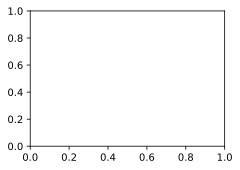

In [62]:
lr, num_epochs = 1, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
    devices)